In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt
import glob
import re
import warnings
from datetime import datetime
import os
import csv
import io                   # [추가] model.summary()를 캡처하기 위해
from contextlib import redirect_stdout
import csv

In [18]:
def trim_and_flatten_data(haptic_df):
    # Haptic: 4, 5th columns (index 3, 4)
    # Robot: 9, 10, 11th columns (index 8, 9, 10)
    haptic_data = haptic_df.iloc[:, [3, 4]].values
    
    # Process NaN values by replacing them with zeros
    haptic_data = np.nan_to_num(haptic_data, nan=0.0)
    return haptic_data.flatten()

In [19]:
def load_all_data(data_base_path):
    base_path = Path(data_base_path) / "DATA"

    all_X_data = []
    all_y_data = []

    METHOD_MAP = {'HAPTICS': 'H', 'NOhaptics': 'NH'}
    TASK_MAP = {
        5: ('pp1', 'PAP'), 6: ('pp1', 'PAP'),
        7: ('pp2', 'PAPObstructed'), 8: ('pp2', 'PAPObstructed'),
        9: ('pp3', 'Camera'), 10: ('pp3', 'Camera')
    }

    for p_id in range(1, 27): # 1~26

        participant_str = f"Participant_{p_id}"
        results_file = base_path / "Haptic Data" / participant_str / f"{participant_str}_results.csv"
        
        results_lookup = {}
        try:
            results_df = pd.read_csv(results_file)
            for _, row in results_df.iterrows():
                try:
                    condition = row['Condition']
                    subcondition = row['Subcondition']
                    trial_str = str(row['Trial'])
                    trial = int(re.search(r'^\d+', trial_str).group())
                    output_1 = pd.to_numeric(row['Sensor1 Mean'], errors='coerce')
                    output_2 = pd.to_numeric(row['Sensor2 Mean'], errors='coerce')

                    if pd.isna(output_1) or pd.isna(output_2):
                        continue
                    key = (condition, subcondition, trial)
                    results_lookup[key] = (output_1, output_2)
                except Exception:
                    continue
        except Exception as e:
            print(f"Error in reading ({results_file}): {e}")
            continue
        haptic_files_glob = glob.glob(str(base_path / "Haptic Data" / participant_str / "*.csv"))

        for hfile_path in haptic_files_glob:
            file_name = Path(hfile_path).name
            match = re.match(r'(\d+)_.*?_(HAPTICS|NOhaptics)_(\d+)\.csv', file_name)
            
            if not match:
                continue

            try:
                task_num = int(match.group(1))
                method = match.group(2)
                trial = int(match.group(3))
                
                if task_num not in TASK_MAP:
                    continue

                scenario_num, result_condition = TASK_MAP[task_num]
                method_short = METHOD_MAP[method]

                output_key = (result_condition, method, trial)
                if output_key not in results_lookup:
                    continue

                haptic_df = pd.read_csv(hfile_path)

                flat_input_vector = trim_and_flatten_data(haptic_df)

                if flat_input_vector is not None:
                    output_1, output_2 = results_lookup[output_key]
                    output_vector = np.array([output_1, output_2])
                    all_X_data.append(flat_input_vector)
                    all_y_data.append(output_vector)
            
                print(f" Success: participant {p_id} task {task_num}, method {method}, trial {trial}")
            except Exception as e:
                print(f"  Error: {file_name} - {e}")

    max_len = max(len(x) for x in all_X_data)
    
    X_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in all_X_data])
    y_array = np.array(all_y_data)

    return X_padded, y_array

In [20]:
def split_data(X, y, test_size=0.2, dev_size=0.125, random_state=42):
    """
    데이터를 훈련, 개발, 테스트 세트로 분리합니다. (기본 70:10:20)
    """
    if X.shape[0] == 0:
        print("오류: 분리할 데이터가 없습니다.")
        return (np.array([]),)*6

    # 1차 분리: 훈련+개발 (80%) / 테스트 (20%)
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 2차 분리: 훈련 (70%) / 개발 (10%)
    X_train, X_dev, y_train, y_dev = train_test_split(
        X_train_dev, y_train_dev, test_size=dev_size, random_state=random_state
    )

    print(f"데이터 분리 완료:")
    print(f"  훈련 (Train)  : {X_train.shape}, {y_train.shape}")
    print(f"  개발 (Dev)    : {X_dev.shape}, {y_dev.shape}")
    print(f"  테스트 (Test) : {X_test.shape}, {y_test.shape}")

    return X_train, X_dev, X_test, y_train, y_dev, y_test

In [21]:
def get_regularizer(config):
    reg_type = config.get('regularizer_type', None)
    l1_val = config.get('l1', 0.01)
    l2_val = config.get('l2', 0.01)

    if reg_type == 'l1': return regularizers.l1(l1_val)
    elif reg_type == 'l2': return regularizers.l2(l2_val)
    elif reg_type == 'l1_l2': return regularizers.l1_l2(l1=l1_val, l2=l2_val)
    else: return None

In [22]:
def build_model(input_shape, model_config):
    model = Sequential(name="Modular_DNN_Model")
    model.add(InputLayer(input_shape=input_shape))

    hidden_layers = model_config.get('hidden_layers', [64, 32])
    activation = model_config.get('activation', 'relu')
    reg_obj = get_regularizer(model_config)

    for units in hidden_layers:
        model.add(Dense(units, activation=activation, kernel_regularizer=reg_obj))
        if model_config.get('use_batch_norm', False):
            model.add(BatchNormalization())
        if model_config.get('dropout_rate', 0.0) > 0:
            model.add(Dropout(model_config['dropout_rate']))

    model.add(Dense(2, name='output')) # 2개 값 예측 (회귀)

    print("모델 구성 완료:")
    # model.summary()
    return model

In [23]:
def compile_and_train_model(model, X_train, y_train, X_val, y_val, train_config):
    loss_function = train_config.get('loss', 'mean_squared_error')
    learning_rate = train_config.get('learning_rate', 0.001)
    optimizer = Adam(learning_rate=learning_rate)
    metrics_list = train_config.get('metrics', ['mean_absolute_error'])

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_list)

    callbacks_list = []
    patience = train_config.get('early_stopping_patience', None)
    
    if patience and patience > 0:
        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=patience,  
            verbose=1,          
            restore_best_weights=True
        )
        callbacks_list.append(early_stop)

    print("\n--- 모델 훈련 시작 ---")
    history = model.fit(
        X_train,
        y_train,
        epochs=train_config.get('epochs', 50),
        batch_size=train_config.get('batch_size', 32),
        validation_data=(X_val, y_val),
        verbose=1
    )
    print("--- 모델 훈련 완료 ---")

    return model, history

In [24]:
def evaluate_model(model, X_test, y_test):
    if X_test.shape[0] == 0:
        print("경고: 평가할 테스트 데이터가 없습니다.")
        return None

    print("\n--- 최종 모델 평가 (Test Set) ---")
    results = model.evaluate(X_test, y_test, verbose=1)
    metric_names = model.metrics_names
    for name, value in zip(metric_names, results):
        print(f"{name}: {value:.4f}")
    return results

In [25]:
def plot_training_history(history,filename=None):
    if not history:
        print("시각화할 훈련 기록(history)이 없습니다.")
        return

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if filename is not None:
        plt.savefig(f"{filename}_loss.png")

    # Metric
    plt.figure(figsize=(12, 5))
    metric_keys = [k for k in history.history.keys() if k not in ['loss', 'val_loss', 'lr']]
    if metric_keys:
        train_metric = metric_keys[0]
        val_metric = f"val_{train_metric}"
        if val_metric in history.history:
            plt.subplot(1, 2, 2)
            plt.plot(history.history[train_metric], label=f'Train {train_metric}')
            plt.plot(history.history[val_metric], label=f'Validation {val_metric}')
            plt.title(f'Model Metric ({train_metric})')
            plt.xlabel('Epochs')
            plt.ylabel('Metric')
            plt.legend()
    plt.tight_layout()
    plt.show()
    if filename is not None:
        plt.savefig(f"{filename}_metric.png")

In [26]:
# --- 5. 평가 및 시각화 모듈 ---
# ... (evaluate_model, plot_training_history 함수는 여기에 있습니다) ...

def plot_predictions(y_true, y_pred,filename=None):
    """
    [수정된 함수]
    Validation set의 실제 값과 예측 값을
    하나의 산점도(scatterplot)에 오버레이하여 그립니다.
    """
    if y_true.shape[0] == 0:
        print("시각화할 검증 데이터가 없습니다.")
        return

    plt.figure(figsize=(8, 8)) # 정사각형 그래프로 변경

    # Output 1 (첫 번째 예측값) - 파란색
    plt.scatter(y_true[:, 0], y_pred[:, 0], 
                alpha=0.5, label='Output 1 Prediction (blue)')
    
    # Output 2 (두 번째 예측값) - 초록색
    plt.scatter(y_true[:, 1], y_pred[:, 1], 
                alpha=0.5, label='Output 2 Prediction (green)')

    plt.xlabel("Actual Values (True Values)")
    plt.ylabel("Predicted Values (Predictions)")
    plt.title("Prediction vs Actual (Overlay)")
    
    # y=x 선 (완벽한 예측)
    # 두 Output의 모든 값(true, pred)을 기준으로 min/max를 계산
    all_values = np.concatenate([y_true.flatten(), y_pred.flatten()])
    lims = [all_values.min() * 0.95, all_values.max() * 1.05] # 약간의 여백 추가
    
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'r--', label='Perfect Prediction (y=x)')
    
    plt.legend() # 범례 표시
    plt.grid(True) # 그리드 추가
    if filename is not None:
        plt.savefig(f"{filename}_comparison.png")
    plt.tight_layout()
    plt.show()
    if filename is not None:
        plt.savefig(f"{filename}_pred.png")

In [27]:
def capture_model_summary(model):
    """Keras 모델의 .summary() 출력을 문자열로 반환합니다."""
    stream = io.StringIO()
    with redirect_stdout(stream):
        model.summary()
    return stream.getvalue()


EXPERIMENT_FIELDNAMES = [
    "timestamp", "architecture", "hidden_layers", "activation", 
    "regularizer", "dropout", "batch_norm", "learning_rate", 
    "batch_size", "n_epochs", "optimizer", "loss_function",
    "train_size", "dev_size", "final_train_loss", "final_dev_loss",
    "best_dev_loss", "best_epoch", "notes"
]

def log_experiment(log_path, model, history, model_config, train_config, X_train, X_val):
    """
    [TensorFlow/Keras 버전]
    훈련 결과를 CSV 파일에 한 줄로 기록합니다.
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    # Keras History 객체에서 Loss 값들을 안전하게 추출
    train_losses = history.history.get('loss', [0.0])
    val_losses = history.history.get('val_loss', [0.0])
    
    # 기록할 파라미터 딕셔너리 생성
    params = {
        "timestamp": timestamp,
        "architecture": capture_model_summary(model), # 모델 구조 요약
        "hidden_layers": str(model_config.get('hidden_layers', [])), # 리스트를 문자열로
        "activation": model_config.get('activation', ''),
        "regularizer": model_config.get('regularizer_type', 'None'),
        "dropout": model_config.get('dropout_rate', 0.0),
        "batch_norm": model_config.get('use_batch_norm', False),
        "learning_rate": train_config.get('learning_rate', 0.0),
        "batch_size": train_config.get('batch_size', 0),
        "n_epochs": train_config.get('epochs', 0),
        "optimizer": model.optimizer.__class__.__name__, # 'Adam' 등
        "loss_function": train_config.get('loss', ''),
        "train_size": len(X_train), # X_train의 크기
        "dev_size": len(X_val),   # X_val의 크기
        "final_train_loss": round(train_losses[-1], 6),
        "final_dev_loss": round(val_losses[-1], 6),
        "best_dev_loss": round(min(val_losses), 6),
        "best_epoch": int(np.argmin(val_losses) + 1), # (numpy as np 필요)
    }
    
    file_exists = os.path.exists(log_path)
    with open(log_path, mode='a', newline='', encoding='utf-8') as f:
        # DictWriter가 params에 없는 키는 'N/A'로, params에 fieldnames에 없는 키는 무시하도록 설정
        writer = csv.DictWriter(f, 
                              fieldnames=EXPERIMENT_FIELDNAMES, 
                              restval='N/A', 
                              extrasaction='ignore')
        
        if not file_exists:
            writer.writeheader() # 파일이 없으면 헤더 쓰기
            
        writer.writerow(params) # 파라미터 한 줄 쓰기

In [28]:
def save_final_model(save_dir, model, history, train_config):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    n_epochs = train_config.get('epochs', 0)
    
    val_losses = history.history.get('val_loss', [0.0])
    final_dev_loss = val_losses[-1] # PyTorch의 avg_dev_loss 대신 final_dev_loss 사용
    
    final_name = f"final_pressureRNN_{timestamp}_epoch{n_epochs}_loss{final_dev_loss:.4f}.weights.h5"
    final_path = os.path.join(save_dir, final_name)
    
    # 3. 모델 가중치 저장
    model.save_weights(final_path)


전체 데이터셋 크기: X=(251, 13015), y=(251, 2)
샘플 예시 (첫 5개):
 X[0]: [1.09300000e+03 1.09300000e+03 3.98323442e-01 1.30944644e-01
 2.25612716e-01 1.09300000e+03 1.09300000e+03 3.97805823e-01
 1.32947335e-01 2.25586813e-01]... , y[0]: [1229.37 1265.18]
 X[1]: [1.10000000e+03 1.09700000e+03 3.96480206e-01 1.66968619e-01
 8.54225292e-02 1.09900000e+03 1.09700000e+03 3.96572410e-01
 1.66840864e-01 8.53901670e-02]... , y[1]: [1212.33 1262.6 ]
 X[2]: [1.09100000e+03 1.09700000e+03 3.86025943e-01 2.56348715e-01
 1.03429745e-01 1.09100000e+03 1.09700000e+03 3.85679345e-01
 2.56984491e-01 1.03078870e-01]... , y[2]: [1229.8  1261.45]
 X[3]: [1.09800000e+03 1.09700000e+03 3.46582132e-01 1.45464625e-01
 1.82133401e-01 1.09800000e+03 1.09700000e+03 3.45056799e-01
 1.47306846e-01 1.80192904e-01]... , y[3]: [1111.96 1117.9 ]
 X[4]: [1.09000000e+03 1.09200000e+03 3.76697965e-01 1.68723332e-01
 1.00762089e-01 1.09000000e+03 1.09200000e+03 3.76697965e-01
 1.68723332e-01 1.00762089e-01]... , y[4]: [1220.12 1238.3

c:\Users\sehui\.conda\envs\CS230\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


모델 구성 완료:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - loss: 1403746.2500 - mean_absolute_error: 1183.6201 - rmse: 1184.7977
loss: 1403746.2500
compile_metrics: 1183.6201


c:\Users\sehui\.conda\envs\CS230\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


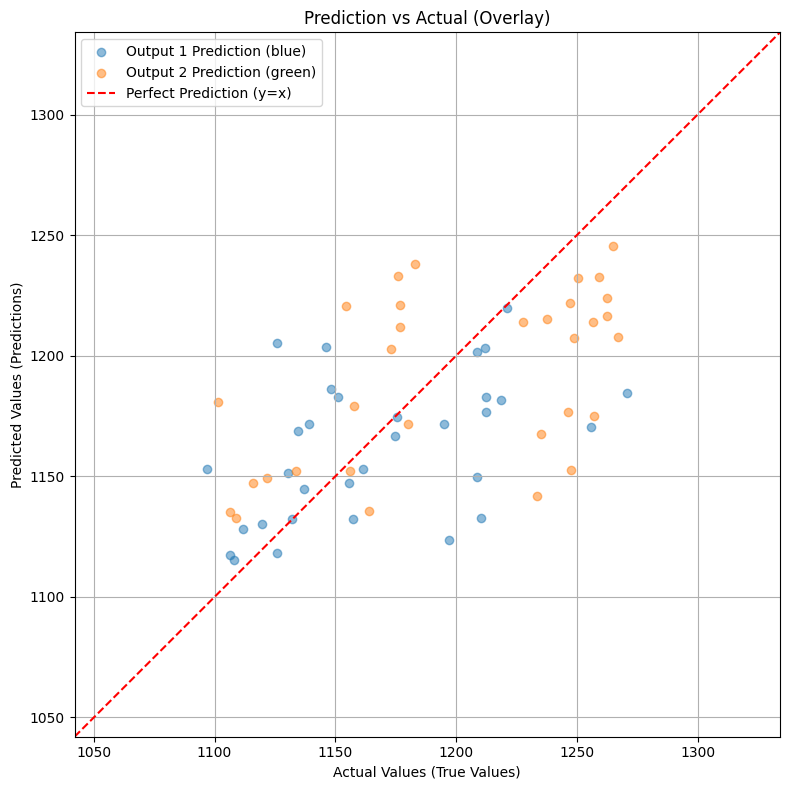

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
27.42810456220401


In [38]:
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

DATA_BASE_PATH_ROOT = r"G:/내 드라이브/CS230 Project"
PROCESSED_DATA_FILE = "processed_hapticrobot_data.npy"
WEIGHTS_FILE_PATH = "results/weights/final_pressureRNN_20251110_110303_epoch500_loss2792.4297.weights.h5"

# 모델 아키텍처 설정
MODEL_CONFIG = {
    'hidden_layers': [128, 64, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
    'activation': 'relu',
    'regularizer_type': 'l2',
    'l2': 0.001,
    'use_batch_norm': True,
    'dropout_rate': 0.
}

# 훈련 설정
TRAIN_CONFIG = {
    'learning_rate': 0.005,
    'epochs': 500,
    'batch_size': 32, # 샘플이 적으므로 배치 크기를 32보다 작게 (16) 조정
    'loss': 'mean_squared_error',
    'metrics': ['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    'early_stopping_patience': 30
}
# ==========================

# 1. 데이터 로드 (검증된 함수 사용)
if os.path.exists(PROCESSED_DATA_FILE):
    data = np.load(PROCESSED_DATA_FILE, allow_pickle=True).item()
    X = data['X']
    y = data['y']
    
else:
    X, y = load_all_data(DATA_BASE_PATH_ROOT)
    data_to_save = {'X': X, 'y': y}
    np.save(PROCESSED_DATA_FILE, data_to_save, allow_pickle=True)

print(f"전체 데이터셋 크기: X={X.shape}, y={y.shape}")
print(f"샘플 예시 (첫 5개):")
for i in range(min(5, X.shape[0])):
    print(f" X[{i}]: {X[i][:10]}... , y[{i}]: {y[i]}")
    
# # 1-Extra. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # 2. 데이터 분리
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_scaled, y,0.15,0.15)

# if X_train.shape[0] == 0:
#     print("데이터 분리에 실패했습니다. (샘플 부족) 프로그램을 종료합니다.")
#     return

# # 3. 모델 구축
input_shape = (X_train.shape[1],)
model = build_model(input_shape, MODEL_CONFIG)

# # 4. 모델 훈련
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=TRAIN_CONFIG.get('learning_rate', 0.001)),
        loss=TRAIN_CONFIG.get('loss', 'mean_squared_error'),
        metrics=TRAIN_CONFIG.get('metrics', ['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    )
results = model.evaluate(X_val, y_val, verbose=1)
metric_names = model.metrics_names
for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")

model.load_weights(WEIGHTS_FILE_PATH)

# # 5. 모델 평가
# evaluate_model(model, X_test, y_test)

# # 6. 결과 시각화
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# plot_filename = os.path.join("results", "plots", f"loss_curve_{timestamp}.png")

# plot_training_history(history,filename=plot_filename)

y_pred_val = model.predict(X_val)
plot_predictions(y_val,y_pred_val)
print(np.sqrt(np.mean((model.predict(X_train)-y_train)**2)))
# LOG_FILE = os.path.join("results", "experiment_logs.csv")
# log_experiment(
#         log_path=LOG_FILE,
#         model=model,
#         history=history,
#         model_config=MODEL_CONFIG,
#         train_config=TRAIN_CONFIG,
#         X_train=X_train,
#         X_val=X_val,
#     )

# save_final_model("results/weights", model, history, TRAIN_CONFIG)

In [34]:
LOG_FILE = os.path.join("results", "experiment_logs.csv")
log_experiment(
        log_path=LOG_FILE,
        model=model,
        history=history,
        model_config=MODEL_CONFIG,
        train_config=TRAIN_CONFIG,
        X_train=X_train,
        X_val=X_val,
    )

save_final_model("results/weights", model, history, TRAIN_CONFIG)

NameError: name 'history' is not defined